In [6]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from scipy.signal import convolve2d
from skimage.draw import circle_perimeter

In [7]:
def dilatacao(a, b):
    # Convertendo as entradas para binário (0 e 1)
    a = a.astype('uint8')
    b = b.astype('uint8')
    # Pegando as dimensões da imagem
    al, ac = a.shape
    bl, bc = b.shape

    # Adicionando padding para evitar erros de borda essa decisão foi tomada para que a função independa da
    # imagem original ter passado por padding
    a_ = (np.zeros((al+2, ac+2))).astype('uint8') # Cria uma matriz de zeros com uma borda maior
    a_[1:1+al, 1:1+ac] = a # Posiciona a matriz "a" no centro de "a_"
    ad = np.zeros_like(a, dtype='uint8') # Matriz de saída com o mesmo tamanho de "a"

    # Aplicando a dilatação
    for i in range(al):
        for j in range(ac):
            # Extraindo a região correspondente
            # Verificando se a região corresponde ao elemento estruturante
            if np.any(a_[i:i + bl, j:j + bc] & b): # Se alguma parte de "a" está contida em "b"
                ad[i, j] = 1                       # então iguala essa parte de "a" a 1

    return ad # Retorna uma imagem com as dimensões da imagem original, mas dilatada

In [8]:
def erosao(a, b):
    # Convertendo as entradas para binário (0 e 1)
    a = a.astype('uint8')
    b = b.astype('uint8')
    # Pegando as dimensões da imagem
    al, ac = a.shape
    bl, bc = b.shape

    # Adicionando padding para evitar erros de borda
    a_ = (np.zeros((al+2, ac+2))).astype('uint8') # Cria uma matriz de zeros com uma borda maior
    a_[1:1+al, 1:1+ac] = a # Posiciona a matriz "a" no centro de "a_"
    ae = np.zeros_like(a, dtype='uint8') # Matriz de saída com o mesmo tamanho de "a"

    # Aplicando a erosão
    for i in range(al):
        for j in range(ac):
            # Extraindo a região correspondente
            # Verificando se a região corresponde ao elemento estruturante
            if np.all((a_[i:i + bl, j:j + bc] & b) == b): # Se toda a parte de "a" está contida em "b" e for igual a "b"
                ae[i, j] = 1                              # então iguala essa parte de "a" a 1

    return ae # Retorna uma imagem com as dimensões da imagem original, mas dilatada

In [9]:
def abertura(img):
    # Realiza a operação de abertura, essa função foi explicada em aula, mas o código é de autoria própria
    b = np.ones ((3,3)).astype('uint8')
    img_op = dilatacao(erosao(img, b), b)
    plt.imshow(img_op,cmap='gray') # Apresenta o resultado

    return img_op

In [10]:
def fechamento(img):
    # Realiza a operação de fechamento para fechar e lacunas buracos. Operação apresentada em aula  mas o código é de autoria própria
    b = np.ones ((3,3)).astype('uint8')
    img_op = erosao(dilatacao(img, b), b)
    plt.imshow(img_op,cmap='gray') # Apresenta o resultado

    return img_op    

In [11]:
image = imread('panda.jpg')    # Imagem binária lida para a atividade. Foi usada essa imagem já binarizada
image = color.rgb2gray (image) # nesse formato por questções de portabilidade para a plataforma, porém
                               # o algoritmo funcionou para outras imagens
                               # O problema enfrentado foi somente de compatibilidade para a leitura do python

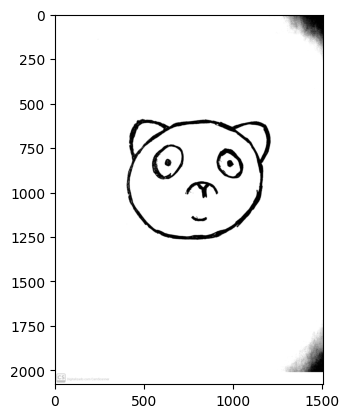

In [12]:
plt.imshow(image,cmap='gray') # Apresentação do desenho

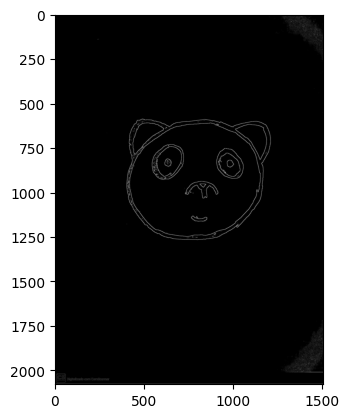

In [13]:
# Aplicação do filtro derivativo de Sobel

mx = np.array ([[-1,-2,-1],[0,0,0],[1,2,1]]) # Máscara de Sobel
my = mx.T

gy = np.abs(convolve2d (image,my,mode='same')) # Uso da função concolve2d do scipy
gx = np.abs(convolve2d (image,mx,mode='same'))
g=gx+gy
plt.imshow(g,cmap='gray') # Apresentação do resultado

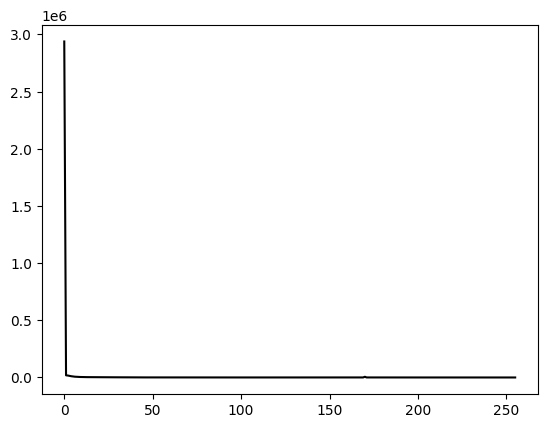

In [14]:
h = np.histogram (g.ravel(),bins=256) # Histograma da imagem que passou por Sobel
plt.plot (h[0],'-k') # Apresentação do resultado

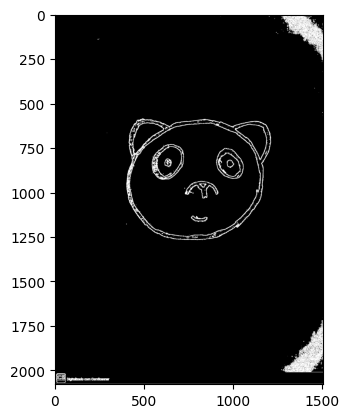

In [15]:
# Binarização da imagem passada por Sobel, como apresentado na aula

binary=g.copy()
limiar = image.max()*(50/256) # Limiar para binarização, retirando a imagem de cinza para preto e branco
binary[binary<=limiar]=0 # Se os valores estiverem abaixo do limiar, o pixel se torna 0 (zero)
binary[binary>0]=1 # Se os valores estiverem acima do limiar, o pixel se torna 1 (um)
plt.imshow(binary*255,cmap='gray') # A presentação do resultado

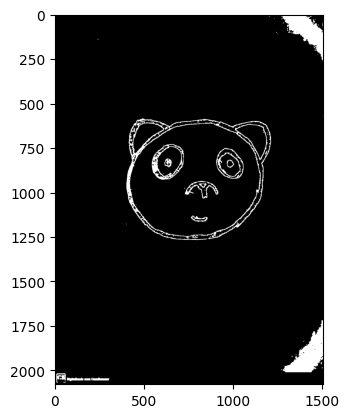

In [16]:
binary = fechamento (binary) # Aplicação da função de fechamento
binary = abertura (binary) # Aplicação da função de abertura
plt.imshow (binary,cmap='gray') # Apresentação do resultado

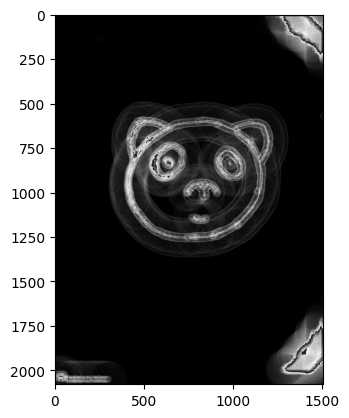

In [17]:
raio = [15, 100]# Foi testado "int(image.shape[0]/3)" em algumas imagens, mas nesse caso não funcionou muito bem
# Definir o tamanho do grade de acumuladores com base no tamanho da imagem
grade = np.zeros((binary.shape[0], binary.shape[1])).astype('uint8')
for y in range(binary.shape[0]): # Caminhando no eixo y
    for x in range(binary.shape[1]): # Caminhando no eixo x
        for r in raio: # Avalia cada ponto (x,y) para um dos raios
            if binary[y, x] > 0: # Verifica somente os pontos que não são 0 (zero)
                # Percorrer ângulos para encontrar possíveis centros
                for theta in range(0, 360, 1):  # Variação de ângulos com a equação com cossenos e senos
                    a = int(x - r * np.cos(np.radians(theta))) # Calcula os a's da equação
                    b = int(y - r * np.sin(np.radians(theta))) # Calcula os b's da equação
                    
                    # Verificar se (a, b) está dentro da imagem
                    if 0 <= a < binary.shape[1] and 0 <= b < binary.shape[0]:
                        grade[b, a] += 1  # Incrementa voto para (a, b)

plt.imshow (grade,cmap='gray') # Apresenta a grade de acumuladores             

In [18]:
max_votos = np.max(grade) # Pega somente os valores máximos da grade de aculadores, os centros dos císculos principais
centros = []  # Lista para armazenar os centros mais votados, que são os melhores candidatos a centros

# Percorrer o grade para encontrar os centros mais votados
for i in range(grade.shape[0]):  # Percorre as linhas (b)
    for j in range(grade.shape[1]):  # Percorre as colunas (a)
        if grade[i, j] == max_votos:
            centros.append((i, j))  # Armazena (b, a)

# Verificação se as listas não estão vazias, o que se mostrou uma possibilidade em algumas imagens
print("Número de centros detectados:", len(centros))
print("Centros:", centros)
print("Raios:", raio)

            

Número de centros detectados: 334
Centros: [(0, 1335), (0, 1342), (2, 1408), (30, 1446), (32, 1447), (36, 1280), (36, 1446), (38, 1287), (41, 1295), (41, 1461), (42, 1294), (42, 1455), (49, 1467), (49, 1468), (55, 1294), (56, 1469), (64, 1302), (66, 1488), (79, 1307), (81, 1309), (83, 1494), (85, 1501), (86, 1500), (95, 1504), (100, 1318), (101, 1313), (108, 1328), (108, 1329), (111, 1336), (113, 1506), (119, 1405), (120, 1346), (120, 1404), (120, 1405), (120, 1406), (122, 1351), (122, 1352), (122, 1353), (122, 1358), (122, 1406), (123, 1507), (125, 1367), (125, 1368), (126, 1406), (134, 1506), (135, 1506), (136, 1506), (141, 1506), (149, 1388), (152, 1506), (157, 1395), (160, 1505), (163, 1505), (164, 1415), (164, 1505), (165, 1423), (167, 1428), (168, 1429), (168, 1430), (168, 1431), (175, 1504), (176, 1504), (177, 1447), (187, 1454), (199, 1504), (200, 1504), (201, 1504), (208, 1504), (209, 1504), (213, 1476), (219, 1498), (220, 1497), (228, 1488), (229, 1488), (603, 494), (605, 481

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


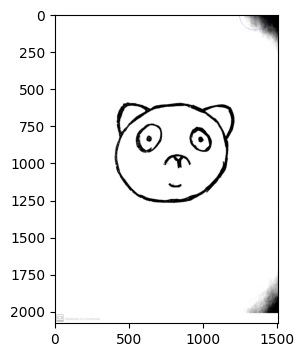

In [ ]:
# Desenho da figura, baseado no código do notebook disponibilizado na aula
# Essa parte apresentou problemas, embora tenha funcionado para um teste com uma imagem formada apenas por círculos simples alinhados
# Ainda assim, está aqui por completude de código, a atividade foi concluída acima
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image_color = color.gray2rgb(image)
for centro, r in zip(centros, raio):
    b, a = centro
    circy, circx = circle_perimeter(b, a, r, shape=image.shape)
    image_color[circy, circx] = (0, 0, 220)

ax.imshow(image_color, cmap=plt.cm.gray)




In [20]:
# Referências:

# https://docs.opencv.org/3.4/d4/d70/tutorial_hough_circle.html

# https://www.ic.unicamp.br/~rocha/msc/ipdi/deteccao_formas_circulares.pdf